## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from typing import List
from codes.utils import get_n_classes_2d_toy_dataset, plot_2d_toy_dataset, plot_losses_and_accuracies, plot_boundries, train_model_for_toy_dataset, plot_ignorance_uncertainity_confusion
from codes.loss import custom_loss, calculate_only_belief_uncertainty_ignorance_confusion

# and set the seed for reproducibility
random_seed = 42
random.seed(random_seed)

## Create the MLP model for classifying the 2D points

In [2]:
class MLP(nn.Module):
    def __init__(self,
                 last_layer_activation: nn.Module,
                 input_dim: int,
                 hidden_dims: List[int],
                 output_dims: int,
                 activation: nn.Module = nn.LeakyReLU(0.2)):
        super(MLP, self).__init__()

        self.last_layer_activation = last_layer_activation

        counter = 0

        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            current_fc_layer = nn.Linear(prev_dim, hidden_dim)
            setattr(self, f'fc_{counter}', current_fc_layer)
            counter += 1
            prev_dim = hidden_dim
        
        last_fc_layer = nn.Linear(prev_dim, output_dims)

        setattr(self, f'fc_{counter}', last_fc_layer)

        self.activation = activation

        self.layer_count = counter + 1
    
    def forward(self, x):
        
        for i in range(self.layer_count):
            x = getattr(self, f'fc_{i}')(x)
            if i != self.layer_count - 1:
                x = self.activation(x)
            else:
                x = self.last_layer_activation(x)
        return x

## Generate the 2D toy dataset

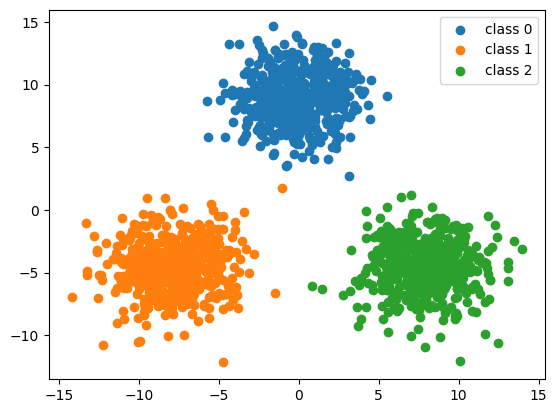

In [3]:
# Generate some data
n_classes = 3
n_samples_per_class = 500
std = 2.0
distance = 9.0
shuffle = True

# set the seed again
random.seed(random_seed)

# Generate the data
X, y = get_n_classes_2d_toy_dataset(n_classes=n_classes,
                                    n_samples_per_class=n_samples_per_class,
                                    std=std,
                                    distance=distance,
                                    random_seed=random_seed,
                                    shuffle=shuffle)

plot_2d_toy_dataset(X, y, n_classes)

## Get the data ready for training

In [4]:
# Split the data into training and test validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# convert labels to one-hot encoding
y_train = np.eye(n_classes)[y_train]
y_validation = np.eye(n_classes)[y_validation]

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)

# print the first 10 data
print(X_train[:10])
print(y_train[:10])

tensor([[ -1.4047,   7.2545],
        [ -8.9650,  -5.7907],
        [  6.8592,  -5.4075],
        [ -1.6235,   7.4181],
        [ -9.1267,  -4.3977],
        [-10.4132,  -1.6801],
        [ -0.6560,   8.0418],
        [-12.5022,  -5.1771],
        [ -7.5617,  -3.7747],
        [  7.0993,  -2.1694]])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


## Define 2 exact MLP models

In [5]:
# create the MLP which will be trained with the classic loss
MLP_classic = MLP(input_dim=2,
                  hidden_dims=[16, 8],
                  output_dims=n_classes,
                  activation=nn.LeakyReLU(0.2),
                  last_layer_activation=nn.Softmax(dim=1))


# print the MLP
print("MLP with classic loss:")
print(MLP_classic)

MLP with classic loss:
MLP(
  (last_layer_activation): Softmax(dim=1)
  (fc_0): Linear(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=8, bias=True)
  (fc_2): Linear(in_features=8, out_features=3, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
)


## Train the classic model

In [6]:
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the loss function for our loss
classic_loss_object = nn.CrossEntropyLoss()

# create the optimizer for the classic loss (SGD with momentum)
optimizer_classic = optim.SGD(MLP_classic.parameters(), lr=0.001, momentum=0.9)


train_loss_classic_loss, train_accuracy_classic_loss, validation_loss_classic_loss, validation_accuracy_classic_loss = train_model_for_toy_dataset(
    model=MLP_classic,
    optimizer=optimizer_classic,
    loss_fn=classic_loss_object,
    device=device,
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation,
    n_epochs=10000,
    verbose=True,
    verbose_every=2000
)

Epoch 1999:
Train loss: 0.5541214942932129, Train accuracy: 0.9991666674613953
Validation loss: 0.5535710453987122, Validation accuracy: 1.0

Epoch 3999:
Train loss: 0.5531606078147888, Train accuracy: 0.9991666674613953
Validation loss: 0.5525549054145813, Validation accuracy: 1.0

Epoch 5999:
Train loss: 0.5528594851493835, Train accuracy: 0.9991666674613953
Validation loss: 0.5522294640541077, Validation accuracy: 1.0

Epoch 7999:
Train loss: 0.5527072548866272, Train accuracy: 0.9991666674613953
Validation loss: 0.5520663857460022, Validation accuracy: 1.0

Epoch 9999:
Train loss: 0.5526117086410522, Train accuracy: 0.9991666674613953
Validation loss: 0.5519670248031616, Validation accuracy: 1.0



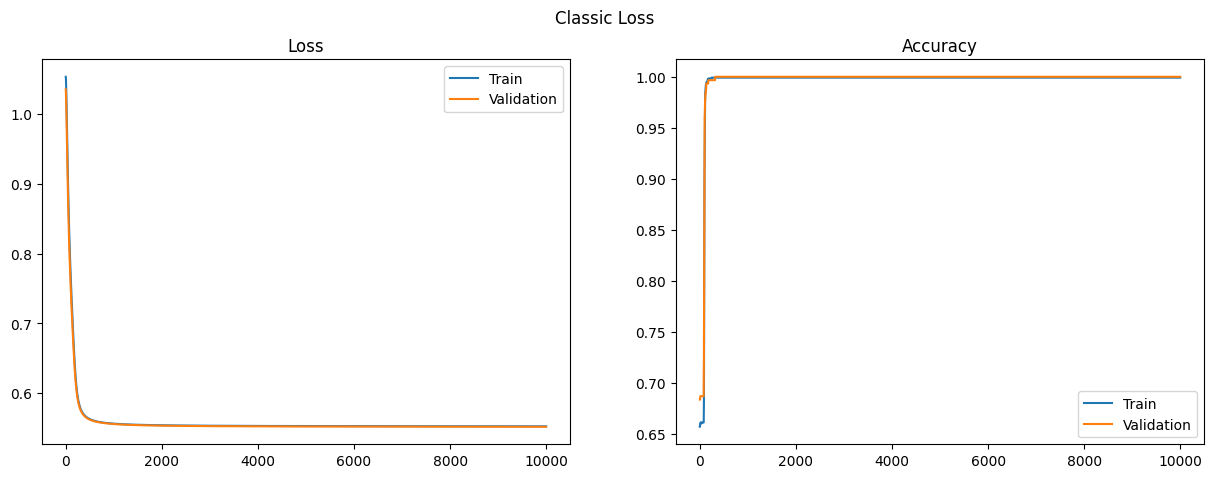

In [7]:
# plot the losses and accuracies
plot_losses_and_accuracies(train_loss_classic_loss,
                           train_accuracy_classic_loss, 
                           validation_loss_classic_loss,
                           validation_accuracy_classic_loss,
                           title="Classic Loss")

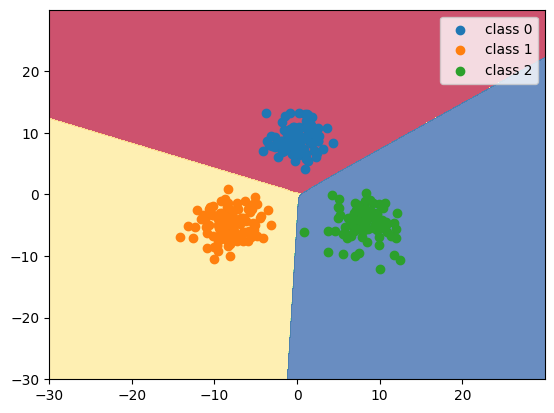

In [8]:
# plot the decision boundries
plot_boundries(MLP_classic,
    device = "cpu",
    X = X_validation,
    y = y_validation,
    n_classes=n_classes,
    plot_step=0.02,
    x_min=-30,
    x_max=30,
    y_min=-30,
    y_max=30
)

## Train the model with custom loss (the papers uncertainity loss)

In [58]:
# create the MLP which will be trained with the losses in the paper
MLP_with_our_loss = MLP(input_dim=2,
                   hidden_dims=[4, 8, 16, 16, 8, 4],
                   output_dims=n_classes,
                   activation=nn.LeakyReLU(0.2),
                   last_layer_activation=nn.Sigmoid())

# print the MLP
print("\nMLP with our loss:")
print(MLP_with_our_loss)


MLP with our loss:
MLP(
  (last_layer_activation): Sigmoid()
  (fc_0): Linear(in_features=2, out_features=4, bias=True)
  (fc_1): Linear(in_features=4, out_features=8, bias=True)
  (fc_2): Linear(in_features=8, out_features=16, bias=True)
  (fc_3): Linear(in_features=16, out_features=16, bias=True)
  (fc_4): Linear(in_features=16, out_features=8, bias=True)
  (fc_5): Linear(in_features=8, out_features=4, bias=True)
  (fc_6): Linear(in_features=4, out_features=3, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
)


In [62]:
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the loss function for our loss
our_loss_object = custom_loss(
    max_epochs=2000,
    max_lambda_kl=0.05,
    annealing_last_value=0.0,
    lambda_reg=1.0
)

# create the optimizer for the our loss (SGD with momentum)
optimizer_our_loss = optim.SGD(MLP_with_our_loss.parameters(), lr=0.001, momentum=0.9)


train_loss_our_loss, train_accuracy_our_loss, validation_loss_our_loss, validation_accuracy_our_loss = train_model_for_toy_dataset(
    model=MLP_with_our_loss,
    optimizer=optimizer_our_loss,
    loss_fn=our_loss_object,
    device=device,
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation,
    n_epochs=5000,
    verbose=True,
    verbose_every=1000
)

Epoch 999:
Train loss: 0.16321833431720734, Train accuracy: 0.9983333349227905
Validation loss: 0.15245841443538666, Validation accuracy: 0.996666669845581

Epoch 1999:
Train loss: 0.055667806416749954, Train accuracy: 0.9991666674613953
Validation loss: 0.05619896203279495, Validation accuracy: 0.996666669845581

Epoch 2999:
Train loss: 0.025715665891766548, Train accuracy: 0.9991666674613953
Validation loss: 0.028356092050671577, Validation accuracy: 0.996666669845581

Epoch 3999:
Train loss: 0.01876772567629814, Train accuracy: 0.9991666674613953
Validation loss: 0.021248510107398033, Validation accuracy: 0.996666669845581

Epoch 4999:
Train loss: 0.016460776329040527, Train accuracy: 0.9991666674613953
Validation loss: 0.01879929006099701, Validation accuracy: 0.996666669845581



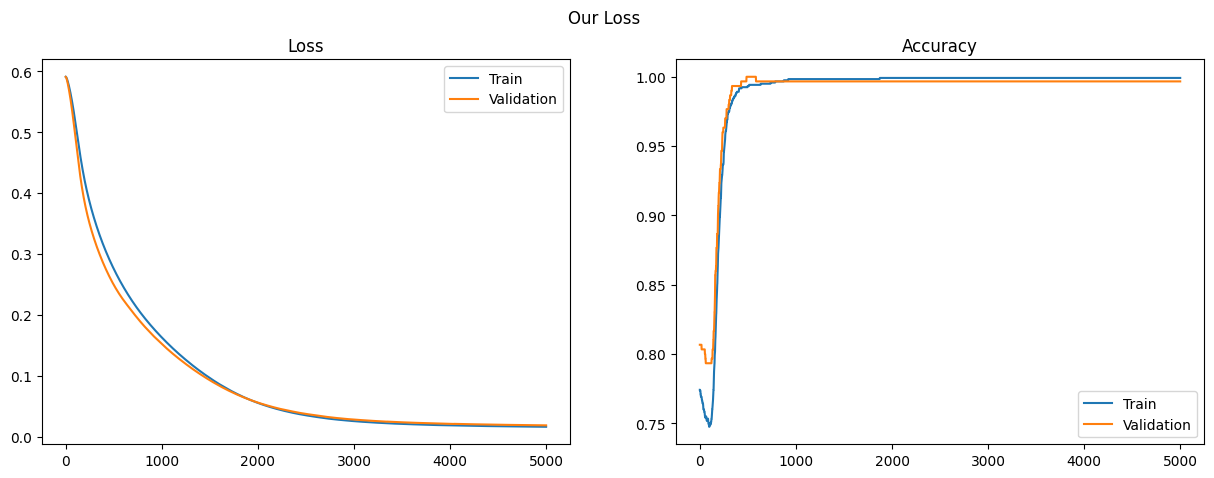

In [63]:
# plot the losses and accuracies
plot_losses_and_accuracies(
    train_loss_our_loss,
    train_accuracy_our_loss,
    validation_loss_our_loss,
    validation_accuracy_our_loss,
    title="Our Loss",
)

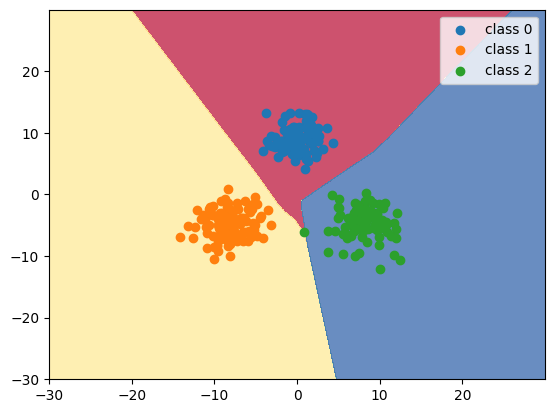

In [64]:
# plot the boundries
plot_boundries(
    model=MLP_with_our_loss,
    device="cpu",
    X=X_validation,
    y=y_validation,
    n_classes=n_classes,
    plot_step=0.02,
    x_min=-30,
    x_max=30,
    y_min=-30,
    y_max=30
)

## Visualize the confusion and ignorance values in boundries

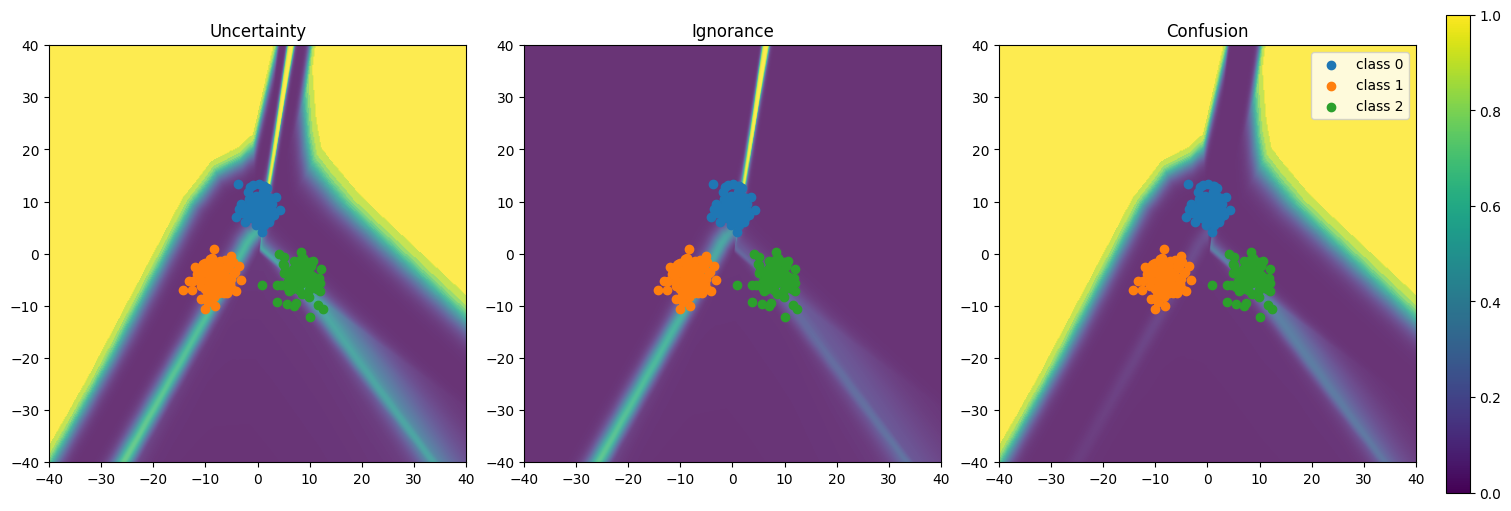

In [65]:
# plot the ignorance, uncertainity and confusion
plot_ignorance_uncertainity_confusion(
    model=MLP_with_our_loss,
    device="cpu",
    X=X_validation,
    y=y_validation,
    n_classes=n_classes,
    plot_step=0.2,
    x_min=-40,
    x_max=40,
    y_min=-40,
    y_max=40
)

In [49]:
# input the 20,20 point and measure the beliefs, uncertainity, ignorance and confusion
x_sample = torch.tensor([[0.0, 8.0]], dtype=torch.float32)

y_pred_sample = MLP_with_our_loss(x_sample)

with torch.no_grad():
    beliefs, uncertainity, ignorance, confusion = calculate_only_belief_uncertainty_ignorance_confusion(y_pred_sample)


print(f"for the point ({x_sample[0,0]},{x_sample[0,1]}):")
print(f"Beliefs: {[float(x) for x in beliefs.numpy()[0]]}")
print(f"Uncertainity: {uncertainity}")
print(f"Ignorance: {ignorance}")
print(f"Confusion: {confusion}")

for the point (0.0,8.0):
Beliefs: [0.8324738144874573, 0.004704075865447521, 0.0020572911016643047]
Uncertainity: tensor([0.1608])
Ignorance: tensor([0.0544])
Confusion: tensor([0.1063])
